In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

os.chdir('../')
from settings.config import Config

import warnings
warnings.filterwarnings('ignore')

In [11]:
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def rle_decode_sum(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T.sum()

### EDA

In [2]:
df = pd.read_csv(Config.masks_path)
df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


After conducting some research on the data available on the internet, I have discovered the presence of data leakage in this competition, resulting from an incorrect step during the cropping process of high-resolution images. The crop size was set to 768, but the crop step was only 256. As a result, certain parts of the full image can be present in the training dataset up to 9 times.

Resolving this issue is crucial, even within the training data, as it is essential to ensure a reliable model scoring on the validation dataset after the split. In the provided mask dataframe, we have two important columns: "imageId" and "EncodedPixels."

- The "imageId" column can be utilized, as it does not follow any logical pattern for splitting in its name. 
- On the other hand, the "EncodedPixels" column contains a string of number pairs. The first part denotes the position number of a pixel, while the second part indicates the number of pixels that belong to the mask. By removing the position numbers and focusing solely on the shape information, we can compare these shapes and eliminate duplicates. Unfortunately, this approach is doing nothing with empty mask.

In [4]:
df_shapes = df.dropna().set_index('ImageId').EncodedPixels.apply(lambda x: ''.join(x.split()[1::2]))
df_shapes

ImageId
000155de5.jpg    1733333333333333333333333333333333343433333333...
000194a2d.jpg                       145810109101099101099910997631
000194a2d.jpg                                   999997777777999999
000194a2d.jpg    1010101010101010101010101010101010101010101010...
000194a2d.jpg                                              1111111
                                       ...                        
fff909871.jpg    2479111211121111121111121112111112111112111211...
fffcb6464.jpg    4101414141415151514141414141414151515151514141...
fffd924fb.jpg                                               555555
fffd924fb.jpg                                     8888888888888888
fffdd2377.jpg    7192626262627272626262626262626262627272626262...
Name: EncodedPixels, Length: 81723, dtype: object

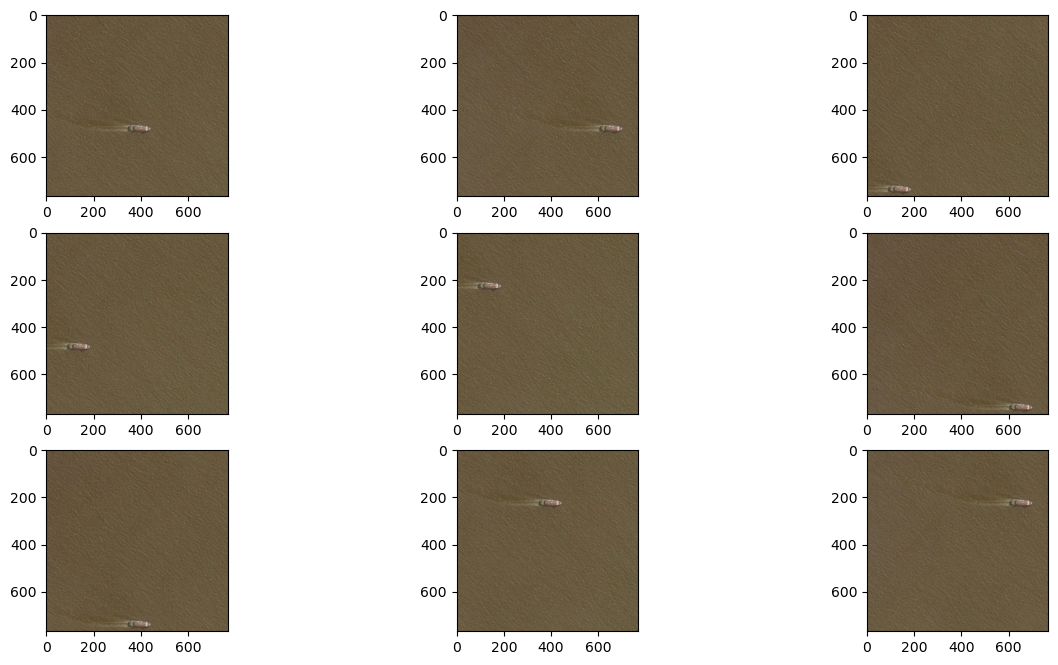

In [29]:
plt.figure(figsize=(15, 8))
for i, im in enumerate(df_shapes[df_shapes == df_shapes[0]].index):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(cv.imread(os.path.join(Config.images_path, im)))

Duplicates have been detected, and for now, we will keep only one image from each set in the dataset. However, this approach is not completely safe. As I demonstrated earlier, the number of unique image names is much smaller than the number of records in the dataframe. This implies that there might be more than one ship present in some images. By removing duplicated ships based on their shape, we run the risk of inadvertently removing some masks from images with multiple ships, thus breaking the mask. We will start by implementing this solution and further evaluate if this problem arises.

However, it is important to note that this approach does not address the case of images with empty masks. Maybe the <b>best solution will be to reconstruct hight resolution</b> image from crops, which is very possible, as crops have very big overlaps.

In [5]:
# construct mask to all images
all_image_masks = df.dropna().groupby('ImageId').EncodedPixels.apply(list).apply(lambda x: ' '.join(x))
# filter only unuque mask images
images_unique_masks = df.dropna().set_index('ImageId').EncodedPixels.apply(lambda x: ''.join(x.split()[1::2])).drop_duplicates().index.drop_duplicates()
# filter in all masks only unique (problem with mask corrupting need to be solved)
masks = all_image_masks[images_unique_masks]
masks

ImageId
000155de5.jpg    264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg    360486 1 361252 4 362019 5 362785 8 363552 10 ...
00021ddc3.jpg    108287 1 109054 3 109821 4 110588 5 111356 5 1...
0002756f7.jpg    255784 2 256552 4 257319 7 258087 9 258854 12 ...
00031f145.jpg    340363 1 341129 4 341896 6 342663 7 343429 10 ...
                                       ...                        
ff7b0a53c.jpg    536102 1 536869 4 537637 5 538404 7 539171 10 ...
ffa24d62d.jpg    235352 1 236119 3 236886 5 237653 8 238421 9 2...
ffb6af57c.jpg    136614 5 137377 10 138145 10 138913 10 139681 ...
ffbbdef34.jpg    111978 2 112746 5 113514 8 114281 13 115049 16...
ffe89d4cb.jpg    63529 1 64296 3 65062 6 65829 7 66596 9 67363 ...
Name: EncodedPixels, Length: 9746, dtype: object

<Axes: xlabel='EncodedPixels'>

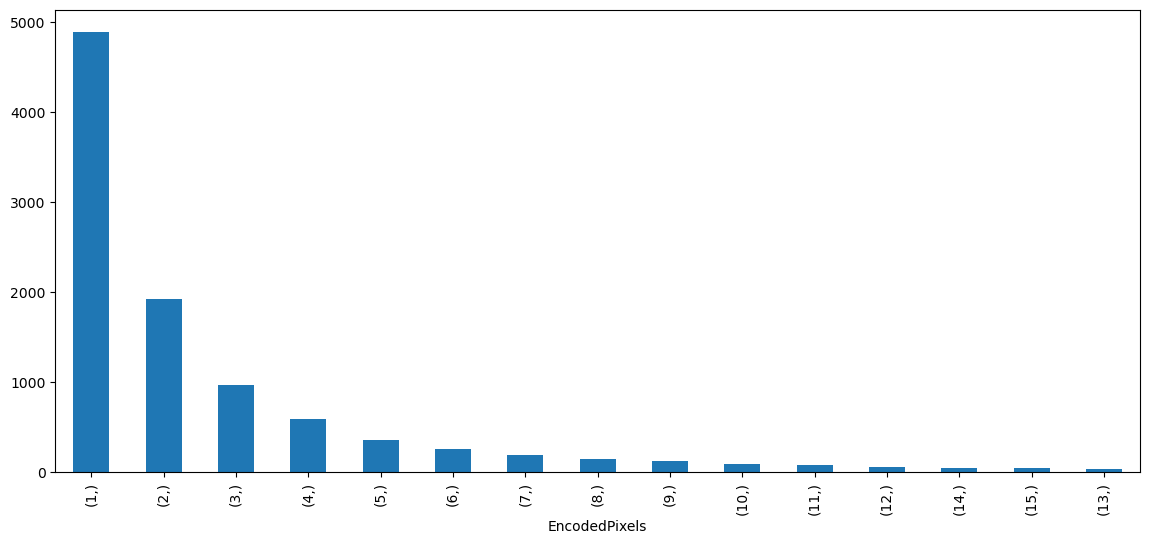

In [6]:
hue = df[df.ImageId.isin(images_unique_masks)].groupby('ImageId').count()
hue.value_counts().plot.bar(figsize=(14,6))

Most of the images contain one or two boats. Considering that the majority of the images have only one or two boats, we can adjust our cropping or scaling approach accordingly. Instead of general cropping or scaling, we can focus on methods that specifically target the boats of interest.

541.0
0.09172227647569445


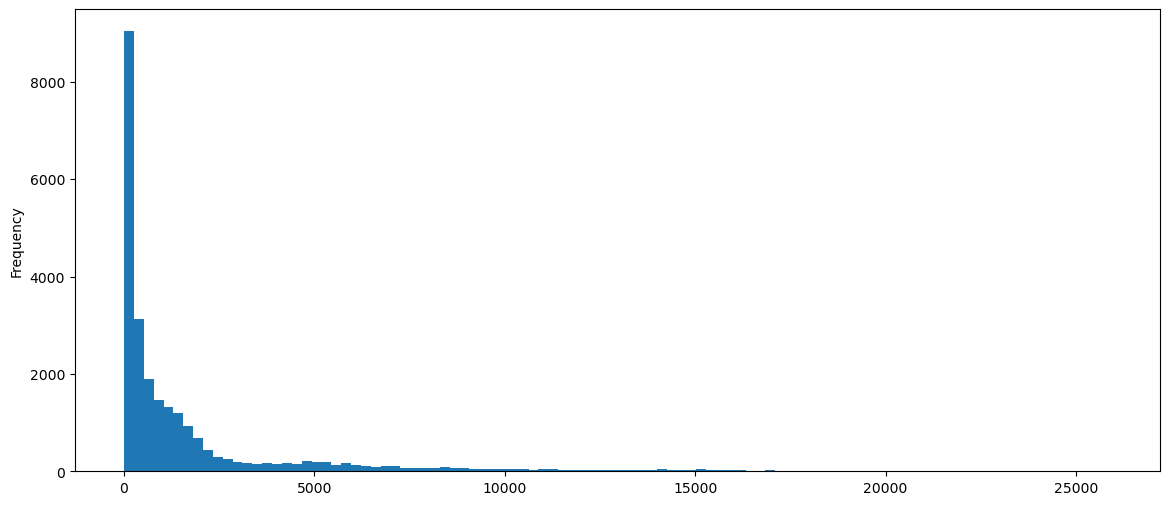

In [95]:
temp = df[df.ImageId.isin(images_unique_masks)]
temp.EncodedPixels = temp.EncodedPixels.apply(rle_decode_sum)
temp.EncodedPixels.plot.hist(bins=100, figsize=(14, 6))
print(temp.EncodedPixels.median())
print(temp.EncodedPixels.median() / 768**2 * 100)

It appears that the objects in the images occupy approximately 550 pixels, which accounts for around 0.09% of the entire image. This proportion is relatively small, indicating that cropping or scaling the training images would be necessary.

<Axes: xlabel='EncodedPixels'>

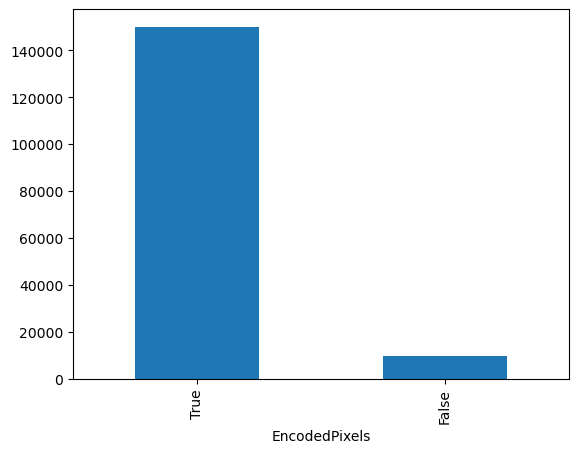

In [7]:
# df only with unique ImageId
temp = pd.concat((masks.reset_index(), df[df.EncodedPixels.isna()]), axis=0)
temp.EncodedPixels.isna().value_counts().plot.bar()

It appears that the dataset is heavily imbalanced, with a significant number of empty masks compared to non-empty masks. To address this issue, I decided to keep only 30% of the empty images, relative to the number of non-empty masks. 

In [8]:
empty_df = df[df.EncodedPixels.isna()].sample(int(masks.shape[0] * 0.3 / 0.7), random_state=Config.random_state)
labels = pd.concat((hue.reset_index(), empty_df.fillna(0)), axis=0)
labels.EncodedPixels = (labels.EncodedPixels > 0).astype(int)
labels = labels.sample(frac=1.0, random_state=Config.random_state)
labels

,ImageId,EncodedPixels
5136,2ef18f6da.jpg,1
50830,387abc625.jpg,0
900,05fa17552.jpg,1
1292,08ac2b250.jpg,1
42795,2f795d2a4.jpg,0
...,...,...
9529,df36a66aa.jpg,1
406,029f377cb.jpg,1
30063,2178e71f6.jpg,0
2191,0f5aff74e.jpg,1


### Conclusions

In [18]:
print(f'N unique images for segmentation: {masks.shape[0]}')
print(f'N unique images for classification: {labels.shape[0]}')

N unique images for segmentation: 9746
N unique images for classification: 13922


We have approximately 10,000 images that we are confident are unique for segmentation training. Further, I will employ augmentation techniques to increase the diversity of the data. Since the presence of objects in the images is sparse compared to the image size, it is beneficial to apply some form of cropping to extract interesting segments from the images. The same applies to the classification task, where we have around 14,000 images.

Given the nature of the dataset, we can observe that the majority of the images do not contain ships. Therefore, it is advisable to first apply a primary filter to determine the presence or absence of a ship in an image before proceeding with segmentation.

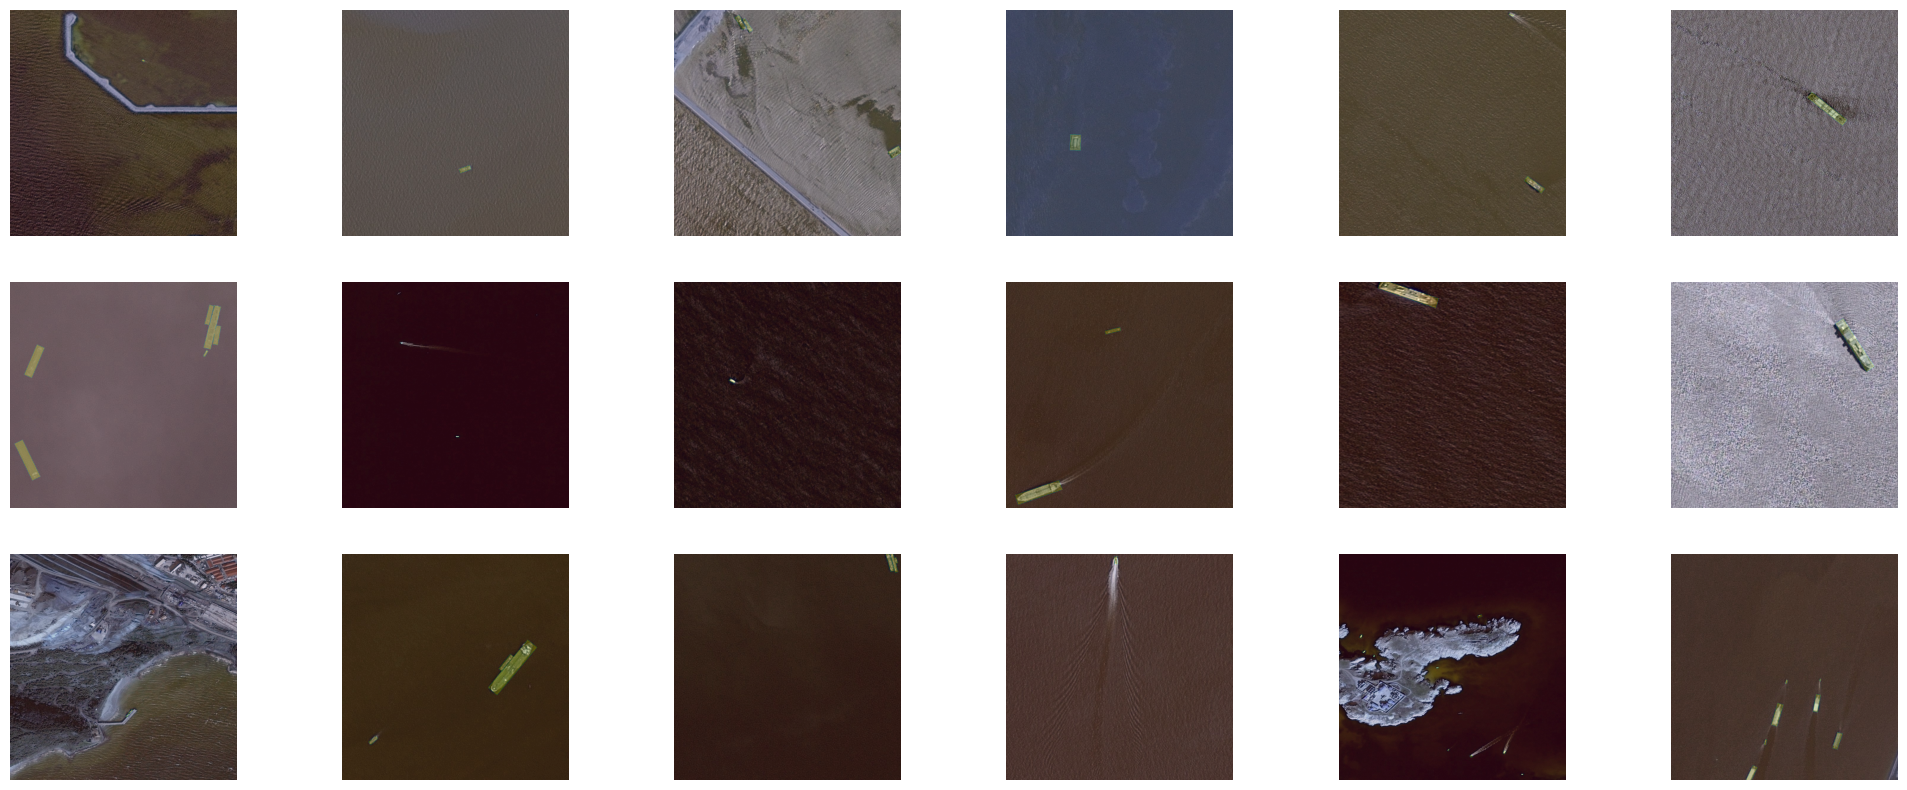

In [84]:
plt.figure(figsize=(25,10))
for i, row in enumerate(masks.to_frame().sample(18).iterrows()):
    ax = plt.subplot(3, 6, i + 1)
    ax.imshow(cv.imread(os.path.join(Config.images_path, row[0])))
    ax.imshow(rle_decode(row[1].values[0]), alpha=0.2)
    ax.axis('off')
plt.show()

After a thorough examination of the image samples, the following observations can be made:

- The majority of images depict ships in open waters.
- There are frequent instances of images featuring docks or ports, where the model may mistakenly perceive them as ships. Therefore, it is advisable to evaluate the model's performance in such scenarios.
- Some images contain overlapping ships, making it challenging for the model to distinguish them as separate objects.
- Certain images exhibit strong wave patterns that resemble white noise. Adding noise to the images could potentially enhance recognition.
- Furthermore, the images vary significantly in terms of clarity and resolution, indicating that there may be multiple sources contributing to the dataset. Developing a classifier to categorize images based on their sources and adapting the model accordingly could be beneficial in the future.
- Some images have significant cloud cover, obscuring parts of the ship or the surrounding area.
- Certain images are damaged, with parts of the image painted black or red.
- Occasionally, there is a drastic contrast in the sizes of the ships, with some being very small and others very large.

In [19]:
hue.reset_index().to_csv('data/hue.csv', index=False)
labels.to_csv('data/labels.csv', index=False)
masks.reset_index().to_csv('data/masks.csv', index=False)